In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from typing import Union
from dataclasses import dataclass

In [109]:
def data_loader(df: pd.DataFrame) -> pd.DataFrame:
    """
    Processes stock price data in a DataFrame by converting dates and resampling to monthly frequency.

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame containing stock price data. Must include a 'Date' column representing daily dates, and other columns corresponding to stock tickers with their daily prices as floats.

    Returns:
    -------
    pd.DataFrame
        A DataFrame indexed by monthly dates (using the first day of each month), where each stock column's value is the first available daily price in each month.

    Notes:
    -----
    - The function infers appropriate data types for each column.
    - The 'Date' column is converted to datetime format and set as the DataFrame index.
    - Monthly resampling is performed with the resampled period labeled and closed on the left.
    """
    df = df.infer_objects()
    df["Date"] = pd.to_datetime(df["Date"])
    df.set_index("Date", drop=True, inplace=True)
    df = df.resample("M", label="left", closed="left").first()
    df = df.diff() / df.shift(1)
    df = df.dropna()
    return df

# utility functions

def calculate_sharpe(ret: Union[float, np.ndarray], std: Union[float, np.ndarray], TBill: float) -> Union[float, np.ndarray]:
    """
    Computes the Sharpe ratio for given returns, volatility, and risk-free rate.

    Parameters:
    ----------
    ret : float or np.ndarray
        Expected return(s) of the investment.
    std : float or np.ndarray
        Standard deviation(s) (volatility) of the investment returns.
    TBill : float
        Risk-free rate (e.g., yield on treasury bills).

    Returns:
    -------
    float or np.ndarray
        The Sharpe ratio, representing the risk-adjusted return.
    """
    return (ret - TBill) / std


def minimize_variance(weights: np.ndarray, cov_matrix: np.ndarray) -> float:
    """
    Calculates the portfolio variance given asset weights and covariance matrix.

    Parameters:
    ----------
    weights : np.ndarray
        Array containing asset allocation weights.
    cov_matrix : np.ndarray
        Covariance matrix of asset returns.

    Returns:
    -------
    float
        The calculated variance of the portfolio.
    """
    variance = np.matmul(np.matmul(weights, cov_matrix), weights)
    return variance


def weight_constraint(weights: np.ndarray) -> float:
    """
    Ensures the sum of portfolio weights equals exactly 1.

    Parameters:
    ----------
    weights : np.ndarray
        Array containing asset allocation weights.

    Returns:
    -------
    float
        The deviation from the target sum (should be 0 for a valid constraint).
    """
    return np.sum(weights) - 1.0


def return_constraint(weights: np.ndarray, returns: np.ndarray, return_target: float) -> float:
    """
    Ensures the expected portfolio return meets a specified target return.

    Parameters:
    ----------
    weights : np.ndarray
        Array containing asset allocation weights.
    returns : np.ndarray
        Array of expected returns for each asset.
    return_target : float
        The target return that the portfolio should achieve.

    Returns:
    -------
    float
        The deviation from the desired target return (should be 0 for a valid constraint).
    """
    return weights @ returns - return_target

@dataclass
class OptimRes:
    res: optimize._optimize.OptimizeResult
    means: np.ndarray
    stds: np.ndarray
    sharpe_array: np.ndarray
    return_array: np.ndarray
    variance_array: np.ndarray

    def plot_efficient_horizon(self) -> None:
        """
        Plots the efficient frontier along with individual asset points and the point with the maximum Sharpe ratio.
        """
        fig, ax = plt.subplots(1,1, figsize=(6,6))
        # Scatter plot for the variance and return of each optimized portfolio
        ax.plot(self.variance_array, self.return_array, "--", label='Efficient frontier under constraints')

        # Scatter plot for the standard deviations and means of individual assets
        ax.scatter(self.stds, self.means, color='blue', label='Individual Assets')

        # Highlight the portfolio with the maximum Sharpe ratio
        max_sharpe_idx = np.argmax(self.sharpe_array)
        ax.scatter(self.variance_array[max_sharpe_idx], self.return_array[max_sharpe_idx], color="red", label='Max Sharpe Ratio')

        # Add labels and legend
        ax.set_xlabel('Variance (%)')
        ax.set_ylabel('Returns (%)')
        ax.set_title('Efficient Frontier with Individual Assets')
        for i, txt in enumerate(self.means.index):
            ax.annotate(txt, (self.stds[i]+1, self.means[i]+1))
        ax.legend()

def markovicz_optimizer(df: pd.DataFrame, risk_free_rate: float) -> OptimRes:
    """
    Optimizes a portfolio using the Markowitz optimization framework by finding the efficient frontier, which
    consists of portfolios that offer the highest expected return for a given level of risk.

    Parameters:
    ----------
    df : pd.DataFrame
        A DataFrame where each column represents the returns of a stock and each row corresponds to a date.
        The returns should be in decimal form (e.g., 0.01 for 1%).

    risk_free_rate : float
        The annual risk-free rate, expressed as a decimal (e.g., 0.03 for 3%). This rate is used in the calculation of the Sharpe ratio.

    Returns:
    -------
    OptimRes dataclass
        - res : optimize._optimize.OptimizeResult
            Return value from scipy optimization function
        - means : pd.Series
            The annualized mean returns for each stock, multiplied by 100 to convert to percentage form.
        - stds : pd.Series
            The annualized standard deviations for each stock, multiplied by 100 to convert to percentage form.
        - sharpe_array : List[float]
            A list of Sharpe ratios for the optimized portfolios, where each portfolio is targeted to a specific return.
        - return_array : List[float]
            A list of targeted returns for which the portfolio was optimized, expressed in percentage form.
        - variance_array : List[float]
            A list of annualized variances for each optimized portfolio, multiplied by 100 to convert to percentage form.

    Notes:
    -----
    The function performs several key operations:
    - It calculates the covariance matrix of the stock returns to understand how stocks move in relation to each other.
    - It standardizes returns and volatilities to an annual scale assuming 252 trading days, suitable for comparison and further analysis.
    - It uses a sequential quadratic programming method (SLSQP) to minimize the variance of the portfolio for a given return,
      constrained by the weights summing to 1 and achieving a specified return.
    - It iterates over a range of possible returns, optimizing the portfolio for each and calculating the corresponding Sharpe ratio.
    - The function assumes that the DataFrame's columns are well-prepared without any preprocessing required for missing data handling.

    Example Usage:
    --------------
    # Assuming `stock_data` is a DataFrame with stock returns and `0.01` is the risk-free rate:
    means, stds, sharpe_ratios, targeted_returns, variances = markovicz_optimizer(stock_data, 0.01)
    """
    
    # Calculate covariance matrix and annualize returns and standard deviations
    cov_matrix = df.cov()
    means = df.mean().apply(lambda x: (x * 12) * 100)
    stds = df.std().apply(lambda x: (x * np.sqrt(12)) * 100)

    # Initialize weights and set bounds for each weight
    lower_bound = 0.0
    upper_bound = 0.3
    weights = np.full(len(df.columns), 1 / len(df.columns))
    bounds = [(lower_bound, upper_bound)] * len(weights)

    return_array = []
    variance_array = []
    sharpe_array = []

    # Iterate through a range of possible returns
    returns_to_iterate_through = np.linspace(0, np.max(means.values), 40)
    for ret in returns_to_iterate_through:
        # Define constraints for weight sum and targeted return
        cons = [{'type': 'eq', 'fun': weight_constraint},
                {'type': 'eq', 'fun': return_constraint, 'args': (means.values, ret)}]

        # Optimize the portfolio for minimum variance under the constraints
        res = optimize.minimize(minimize_variance, x0=weights, args=(cov_matrix,), method='SLSQP', constraints=cons, bounds=bounds)

        if res.success:
            # Calculate Sharpe ratio and adjust variance to annualized percent form
            sharpe_ratio = calculate_sharpe(ret, np.sqrt(res.fun) * np.sqrt(12) * 100, risk_free_rate)
            sharpe_array.append(sharpe_ratio)
            return_array.append(ret)
            variance_array.append(np.sqrt(res.fun) * np.sqrt(12) * 100)

    return OptimRes(res, means, stds, sharpe_array, return_array, variance_array)

In [110]:
df = pd.read_csv("test_for_portfolio_optimization - extracted_prices.csv")

In [111]:
df_mod = data_loader(df)

In [112]:
res = markovicz_optimizer(df=df_mod, risk_free_rate=3.5)

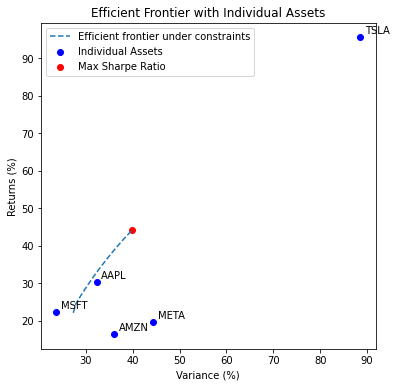

In [114]:
res.plot_efficient_horizon()